# MediQA 2023 - Task C: Note2Dialogue with BART (Similar structura Task A)

Train shape: (67, 4)
Validation shape: (20, 4)
Test shape: (40, 4)
Train columns: Index(['dataset', 'encounter_id', 'dialogue', 'note'], dtype='object')


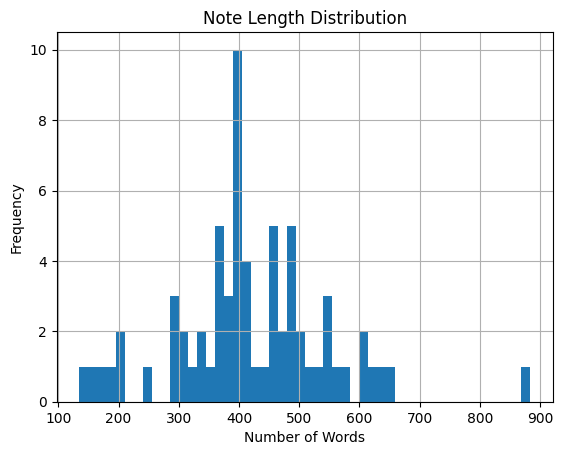

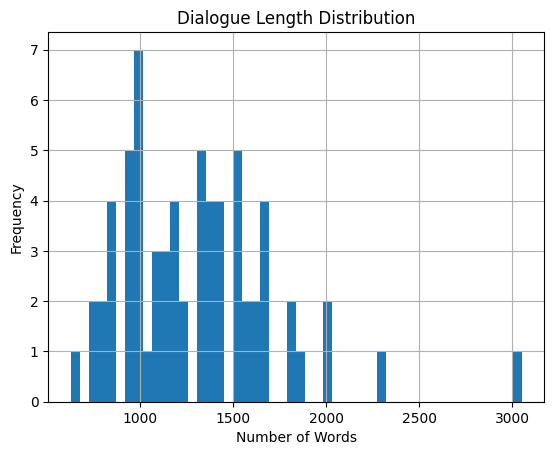

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import evaluate
import torch

# Load datasets
train_df = pd.read_csv('dataset/B/train.csv')
val_df = pd.read_csv('dataset/B/valid.csv')
test_df = pd.read_csv('dataset/B/clinicalnlp_taskC_test2.csv')

# EDA
print('Train shape:', train_df.shape)
print('Validation shape:', val_df.shape)
print('Test shape:', test_df.shape)
print('Train columns:', train_df.columns)

train_df['note_length'] = train_df['note'].apply(lambda x: len(str(x).split()))
plt.figure()
train_df['note_length'].hist(bins=50)
plt.title('Note Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

train_df['dialogue_length'] = train_df['dialogue'].apply(lambda x: len(str(x).split()))
plt.figure()
train_df['dialogue_length'].hist(bins=50)
plt.title('Dialogue Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Tokenizer & Model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')

max_input_length = 512
max_target_length = 512

def preprocess_data(examples):
    # Prompt engineering discret
    inputs = [
        "Patient Note:\n" + note + "\n\nInstruction: Generate a detailed, realistic doctor-patient conversation based on this note."
        for note in examples['note']
    ]
    targets = examples['dialogue']
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=max_target_length, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    return model_inputs


train_dataset = Dataset.from_pandas(train_df[['note', 'dialogue']])
val_dataset = Dataset.from_pandas(val_df[['note', 'dialogue']])

tokenized_train = train_dataset.map(preprocess_data, batched=True, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(preprocess_data, batched=True, remove_columns=val_dataset.column_names)

Map:   0%|          | 0/67 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [7]:
# Training setup
training_args = TrainingArguments(
    output_dir='./mediqa_taskC_bart',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=10,
    weight_decay=0.01,
    save_total_limit=2,
    logging_steps=100,
    logging_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
)

trainer.train()

/var/folders/xk/jnrp42td7w1dgf4dpccfj6y00000gn/T/ipykernel_52179/741253529.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/radugheorghe/Programs/BioNLP-MEDIQA-Chat-2023/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,3.430500,2.429534
2,2.512800,2.270467
3,2.305600,2.171002
4,2.161300,2.136438
5,2.092700,2.109305
6,2.006800,2.109301
7,1.930300,2.102313
8,1.869900,2.099180
9,1.852000,2.083658
10,1.824600,2.088235


/Users/radugheorghe/Programs/BioNLP-MEDIQA-Chat-2023/venv/lib/python3.13/site-packages/transformers/modeling_utils.py:3685: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/Users/radugheorghe/Programs/BioNLP-MEDIQA-Chat-2023/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=170, training_loss=2.198652177698472, metrics={'train_runtime': 312.4844, 'train_samples_per_second': 2.144, 'train_steps_per_second': 0.544, 'total_flos': 725980041707520.0, 'train_loss': 2.198652177698472, 'epoch': 10.0})

In [8]:
# Generate predictions and evaluate on TEST

model = model.to('cpu')

gen_outputs = []

for note in test_df['note']:
    inputs = tokenizer(
        "Patient Note:\n" + note + "\n\nInstruction: Generate a detailed, realistic doctor-patient conversation based on this note.",
        return_tensors='pt',
        truncation=True,
        max_length=max_input_length,
        padding='max_length'
    )
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_length=max_target_length,
            num_beams=4,
            length_penalty=1.0,     
            no_repeat_ngram_size=3,
            early_stopping=False,  
        )

    gen_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    gen_text = gen_text.replace("[doctor]", "\n[doctor]").replace("[patient]", "\n[patient]").strip()
    gen_outputs.append(gen_text)

test_df['generated_dialogue'] = gen_outputs

test_df.to_csv('output/MEDIQA_TaskC_Test_Predictions.csv', index=False)
print('Predictions on TEST saved.')

references = test_df['dialogue'].astype(str).tolist()
predictions = test_df['generated_dialogue'].astype(str).tolist()

import evaluate
rouge = evaluate.load('rouge')
scores = rouge.compute(predictions=predictions, references=references)

print('===== ROUGE Scores on TEST Set =====')
for key, value in scores.items():
    print(f'{key}: {value:.4f}')

analysis_df = pd.DataFrame({
    'Note': test_df['note'],
    'Ground Truth Dialogue': references,
    'Predicted Dialogue': predictions
})
analysis_df.head(20).to_csv('output/MEDIQA_TaskC_Test_Top20.csv', index=False)
print('Top 20 TEST samples saved.')


Predictions on TEST saved.
===== ROUGE Scores on TEST Set =====
rouge1: 0.4095
rouge2: 0.1724
rougeL: 0.1610
rougeLsum: 0.3657
Top 20 TEST samples saved.
